# Import

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os
import time
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re
import random

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import LocalCluster, Client

sys.path.insert(0, 'tools/')

from tools import * 

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn import neighbors
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

In [4]:
import tensorflow as tf
from tensorflow import keras

2023-06-12 02:03:33.931094: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-12 02:03:33.967417: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 02:03:34.535255: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Read files

In [5]:
%%time

X_train = pd.read_csv('dades/processed/training_data.csv', index_col='index')
# y_train = pd.read_csv('dades/processed/training_label.csv', index_col='index')
X_train = X_train.reset_index(drop=True)
y_train = X_train.ctx0.copy()
#X_train.drop(columns=['ctx0'], axis=1, inplace=True)

X_val1 = pd.read_csv('dades/processed/validation_data.csv', index_col='index')
# y_val1 = pd.read_csv('dades/processed/validation_label.csv', index_col='index')
X_val1 = X_val1.reset_index(drop=True)
y_val1 = X_val1.ctx0.copy()
#X_val1.drop(columns=['ctx0'], axis=1, inplace=True)

# X_val2 = pd.read_csv('dades/processed/testing_data.csv', index_col='index')
# # y_val2 = pd.read_csv('dades/processed/testing_label.csv', index_col='index')
# X_val2 = X_val2.reset_index(drop=True)
# y_val2 = X_val2.ctx0.copy()
# #X_val2.drop(columns=['ctx0'], axis=1, inplace=True)


CPU times: user 16.6 s, sys: 1.62 s, total: 18.2 s
Wall time: 18.2 s


# Run pipeline

In [6]:
X_train.columns

Index(['station_id', 'year', 'month', 'dayofweek', 'day', 'dayofyear', 'hour',
       'capacity', 'ctx0', 'ctx1', 'ctx2', 'ctx3', 'ctx4', 'festius',
       'festius_sun', 'festius_sun_sat', 'weekend', 'VALOR_TM_D5',
       'VALOR_TX_D5', 'VALOR_TN_D5', 'VALOR_HRM_D5', 'VALOR_PPT_D5',
       'VALOR_PM_D5', 'VALOR_RS24h_D5', 'VALOR_VVM10_D5', 'VALOR_DVM10_D5',
       'VALOR_VVX10_D5', 'VALOR_DVVX10_D5', 'VALOR_HRX_D5', 'VALOR_HRN_D5',
       'VALOR_PX_D5', 'VALOR_PN_D5', 'VALOR_TM_X2', 'VALOR_TX_X2',
       'VALOR_TN_X2', 'VALOR_HRM_X2', 'VALOR_HRX_X2', 'VALOR_HRN_X2',
       'VALOR_TM_X4', 'VALOR_TX_X4', 'VALOR_TN_X4', 'VALOR_HRM_X4',
       'VALOR_PPT_X4', 'VALOR_PM_X4', 'VALOR_RS24h_X4', 'VALOR_VVM10_X4',
       'VALOR_DVM10_X4', 'VALOR_VVX10_X4', 'VALOR_DVVX10_X4', 'VALOR_HRX_X4',
       'VALOR_HRN_X4', 'VALOR_PX_X4', 'VALOR_PN_X4', 'VALOR_TM_X8',
       'VALOR_TX_X8', 'VALOR_TN_X8', 'VALOR_HRM_X8', 'VALOR_PPT_X8',
       'VALOR_PM_X8', 'VALOR_RS24h_X8', 'VALOR_VVM10_X8', 'VALOR_DVM1

In [7]:
columns_meteo = ['VALOR_TM_X4', 'VALOR_PPT_X4']

class Config:
    num_attribs0 = ['capacity', 'ctx1', 'ctx2', 'ctx3', 'ctx4'] + columns_meteo
    cat_attribs0 = ['month', 'dayofyear', 'day', 'hour']
    cat_attribs1 = ['dayofweek']
    gen_attribs0 = ['station_id', 'festius_sun', 'weekend'] # year
    target_col = ['ctx0']

    epochs=50
    batch_size=128
    seed=42
    lr=1e-4

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)
    

In [8]:
config=Config()
seed_everything(config.seed)

In [9]:

def build_preprocessor(config):
    num_attribs0 = config.num_attribs0
    cat_attribs0 = config.cat_attribs0
    cat_attribs1 = config.cat_attribs1
    gen_attribs0 = config.gen_attribs0

    num_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ('std_scaler', (StandardScaler())),
    ])

    categorical_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
        ('ordinal_encoder', (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))),
    ])
    
    categorical_transformer1 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
        ('one_hot_encoder', (OneHotEncoder(handle_unknown='ignore'))),
    ])
    
    generic_transformer0 = Pipeline([
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num0", num_transformer0, num_attribs0),
            ("gen1", generic_transformer0, gen_attribs0),
            ("cat0", categorical_transformer0, cat_attribs0),
            ("cat1", categorical_transformer1, cat_attribs1),
        ],
        remainder="drop"
    )
    
    return preprocessor

In [10]:
%%time 

full_pipeline = build_preprocessor(config)

X_train_prepared = full_pipeline.fit_transform(X_train)
X_val_prepared1 = full_pipeline.transform(X_val1)
# X_val_prepared2 = full_pipeline.transform(X_val2)

print("x_train_prepared:",X_train_prepared.shape,"y_train: ",y_train.shape)
print("x_test_prepared:",X_val_prepared1.shape,"y_test: ",y_val1.shape)
# print("x_test_prepared:",X_val_prepared2.shape,"y_test: ",y_val2.shape)


x_train_prepared: (3541851, 21) y_train:  (3541851,)
x_test_prepared: (882910, 21) y_test:  (882910,)
CPU times: user 2 s, sys: 40.4 ms, total: 2.04 s
Wall time: 2.04 s


In [11]:
X_train_prepared

array([[ 2.94981964,  0.05071035,  0.05071967, ...,  0.        ,
         0.        ,  1.        ],
       [ 2.94981964,  0.05071035,  0.05071967, ...,  0.        ,
         0.        ,  1.        ],
       [ 2.94981964,  0.05071035,  0.05071967, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.06288951, -0.21123279, -0.21120568, ...,  0.        ,
         1.        ,  0.        ],
       [-0.06288951, -0.49474773, -0.49470136, ...,  0.        ,
         1.        ,  0.        ],
       [-0.06288951, -0.35299026, -0.35295352, ...,  0.        ,
         1.        ,  0.        ]])

In [12]:
X_train_prepared.shape

(3541851, 21)

# Needed for NN

# Predicción______________________________

a) Regresión lineal: relación lineal entre las variables de entrada y la variable de salida. 

b) Regresión Redes Neuronales (RNN -redes neuronales recurrentes-): pueden capturar relaciones no lineales entre las variables de entrada y salida.

In [13]:
print(keras.__version__)
print(tf.__version__)
print(tf.test.gpu_device_name())

2.12.0
2.12.0
/device:GPU:0


2023-06-12 02:03:55.734016: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /device:GPU:0 with 9784 MB memory:  -> device: 0, name: NVIDIA RTX A2000 12GB, pci bus id: 0000:68:00.0, compute capability: 8.6


In [14]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2023-06-12 02:03:55.746857: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /device:GPU:0 with 9784 MB memory:  -> device: 0, name: NVIDIA RTX A2000 12GB, pci bus id: 0000:68:00.0, compute capability: 8.6


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18235321282777707810
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10259922944
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16721110273464604421
 physical_device_desc: "device: 0, name: NVIDIA RTX A2000 12GB, pci bus id: 0000:68:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [15]:
# clear previous session
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [16]:
import concurrent.futures
import logging
import sys
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [17]:
from keras import backend as K
# Configuring a session
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=3,
    inter_op_parallelism_threads=3
)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#K.set_session(sess)
tf.compat.v1.keras.backend.set_session(sess)

2023-06-12 02:03:55.761821: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9784 MB memory:  -> device: 0, name: NVIDIA RTX A2000 12GB, pci bus id: 0000:68:00.0, compute capability: 8.6


In [18]:
from keras.callbacks_v1 import TensorBoard
from keras.callbacks import ReduceLROnPlateau

In [19]:
X_train_prepared.shape[1] # 408 + 11 

21

In [20]:
# indicate the input shape
input_shape = X_train_prepared.shape[1]
print(input_shape)

21


In [21]:
def root_mean_squared_error(y_true, y_pred):
    y = K.cast(y_true, K.np.float32)
    y_hat = K.cast(y_pred, K.np.float32)
    return K.sqrt(K.mean(K.square(y_hat - y)))

In [23]:
from keras.callbacks_v1 import TensorBoard
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

final_model = keras.models.Sequential([
    keras.layers.Input(
        shape=(input_shape,)
    ),
    keras.layers.Dense(
        input_shape//0.85, activation="relu"
    ),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(
        input_shape//0.95, activation="relu"
    ),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(
        input_shape//2, activation="relu"
    ),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(
        input_shape//4, activation="relu"
    ),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(
        input_shape//8, activation="relu"
    ),
    keras.layers.Dense(1)
])

final_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999),
    loss=root_mean_squared_error,
    metrics=[
        'RootMeanSquaredError',
        'MeanAbsoluteError',
        'MeanSquaredError'       
    ]
)

# tensorboard=TensorBoard(log_dir="Model_log")
# define a call back
checkpoint_cb = keras.callbacks.ModelCheckpoint("./checkpoints/year_22_nn.h5", verbose=2, monitor='val_loss', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=2, restore_best_weights=True)

# Set a learning rate annealer - to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.
# The LR is decreased dynamically when the score is not improved. This keeps the advantage of the fast computation time with a high LR at the start.
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',  # Track the score on the validation set
    patience=5,  # Number of epochs in which no improvement is seen.
    verbose=2,
    factor=0.8,  # Factor by which the LR is multiplied.
    min_lr=0.0000001  # Don't go below this value for LR.
)

2023-06-12 02:05:29.458895: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9784 MB memory:  -> device: 0, name: NVIDIA RTX A2000 12GB, pci bus id: 0000:68:00.0, compute capability: 8.6


In [24]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                528       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 22)                550       
                                                                 
 dropout_1 (Dropout)         (None, 22)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                230       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                 5

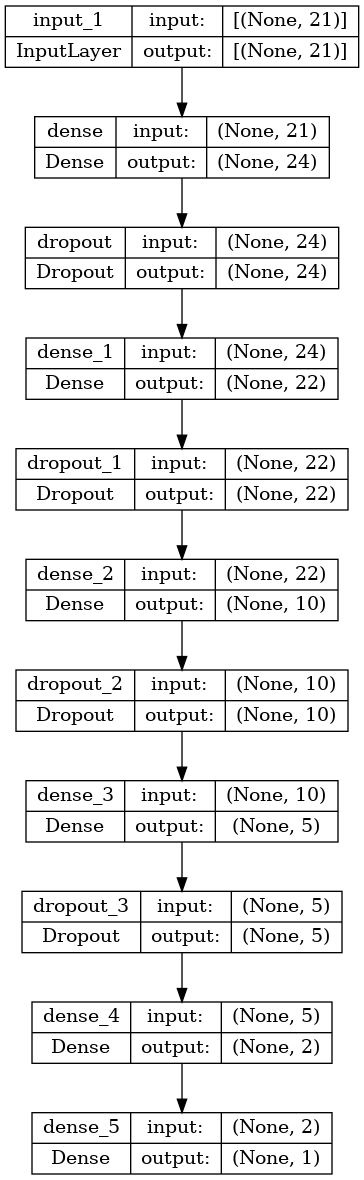

In [25]:
keras.utils.plot_model(final_model, "model.png", show_shapes=True)

In [26]:
history = final_model.fit(X_train_prepared, y_train, 
                          batch_size=config.batch_size,
                          epochs=config.epochs, 
                          validation_data=(X_val_prepared1, y_val1), 
                          callbacks=[checkpoint_cb, early_stopping_cb, learning_rate_reduction]
                         )


Epoch 1/50


2023-06-12 02:05:30.754467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3541851,1]
	 [[{{node Placeholder/_11}}]]
2023-06-12 02:05:30.754685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3541851,1]
	 [[{{node Placeholder/_11}}]]
2023-06-12 02:05:32.192395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-12 02:05:32.195058: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f94c102fe60 initialized 

27658/27671 [============================>.] - ETA: 0s - loss: 1.4391 - root_mean_squared_error: 6.2485 - mean_absolute_error: 0.7755 - mean_squared_error: 39.0441

2023-06-12 02:06:37.998516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [882910,1]
	 [[{{node Placeholder/_11}}]]
2023-06-12 02:06:37.998711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [882910,1]
	 [[{{node Placeholder/_11}}]]



Epoch 1: val_loss improved from inf to 0.26114, saving model to ./checkpoints/year_22_nn.h5
27671/27671 [==============================] - 74s 3ms/step - loss: 1.4385 - root_mean_squared_error: 6.2471 - mean_absolute_error: 0.7752 - mean_squared_error: 39.0262 - val_loss: 0.2611 - val_root_mean_squared_error: 0.2631 - val_mean_absolute_error: 0.2259 - val_mean_squared_error: 0.0692 - lr: 1.0000e-04
Epoch 2/50
27670/27671 [============================>.] - ETA: 0s - loss: 0.2610 - root_mean_squared_error: 0.2613 - mean_absolute_error: 0.2199 - mean_squared_error: 0.0683
Epoch 2: val_loss improved from 0.26114 to 0.26029, saving model to ./checkpoints/year_22_nn.h5
27671/27671 [==============================] - 71s 3ms/step - loss: 0.2610 - root_mean_squared_error: 0.2613 - mean_absolute_error: 0.2199 - mean_squared_error: 0.0683 - val_loss: 0.2603 - val_root_mean_squared_error: 0.2622 - val_mean_absolute_error: 0.2249 - val_mean_squared_error: 0.0688 - lr: 1.0000e-04
Epoch 3/50
27647/2


KeyboardInterrupt



## Generate Sample

In [ ]:
sample_data = pd.read_csv('dades/processed/kaggle_sample_data.csv')

In [ ]:
sample_data

# apply pipeline

# Prediction 

In [ ]:
X_test_prepared = full_pipeline.transform(sample_data)

print("x_train_prepared:",X_train_prepared.shape,"y_train: ",y_train.shape)
print("x_test_prepared:",X_val_prepared1.shape,"y_test: ",y_val1.shape)
print("x_test_prepared:",X_val_prepared2.shape,"y_test: ",y_val2.shape)
print("x_test_prepared:",X_test_prepared.shape)

In [ ]:
yhat = lin_reg.predict(X_test_prepared)


In [ ]:
yhat.shape

In [ ]:
sample_data['percentage_docks_available'] = yhat

In [ ]:
sample_data['percentage_docks_available'].to_csv('predicton_RandomForest.csv', header=True, index_label='index')